In [64]:
import os
import csv
from sklearn import metrics, cluster
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import math
import PIL
from PIL import Image
import argparse
import shutil
import pandas as pd 

from torchvision import transforms
import logging
import os
import pickle

import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

import models.patchcore as patchcore
import models.patchcore.backbones
import models.patchcore.common
import models.patchcore.sampler
import models.patchcore.datasets.mvtec as mvtec
from models.patchcore.datasets.mvtec import IMAGENET_MEAN, IMAGENET_STD
from models.patchcore.utils import Matrix_Alpha_Unsupervised, Matrix_Alpha_Supervised
from models.patchcore.patchcore import AnomalyClusteringCore  # This is originated from PatchCore and it is modified a little bit.
# import test
from utils.bricks import same_seeds

from munkres import Munkres
LOGGER = logging.getLogger(__name__)
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"



def visualize(image, feature_PIL, alpha_PIL, name, image_name):
    # 使用pillow库读取图片
    fig = plt.figure(figsize=(12, 4))
    # process = transforms.Compose([transforms.Resize([256, 256]),
    #                               transforms.CenterCrop(224)])

    # img = Image.open(image_path[0]).convert("RGB")
    # img = process(img)
    ax1 = fig.add_subplot(131)
    ax1.imshow(image)

    ax2 = fig.add_subplot(132)
    ax2.imshow(feature_PIL)
    
    ax3 = fig.add_subplot(133)
    ax3.imshow(alpha_PIL)
    os.makedirs("out\\" + name + "\\visualize", exist_ok=True)

    fname = os.path.join("out\\" + name, "visualize", image_name)
    plt.savefig(fname)
    print(f"{fname} saved.")

def best_map(L1, L2):
    # L1 should be the labels and L2 should be the clustering number we got
    Label1 = np.unique(L1)       # 去除重复的元素，由小大大排列
    nClass1 = len(Label1)        # 标签的大小
    Label2 = np.unique(L2)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1, nClass2)
    G = np.zeros((nClass, nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i, j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:, 1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2

In [80]:

classname = 'leather'
path = 'data/mvtec_ad'
# 参数赋值
pretrain_embed_dimension = 2048
target_embed_dimension = 4096
backbone_names = "dino_vitbase8"
layers_to_extract_from = ["blocks.10", "blocks.11"]
# layers_to_extract_from = ["blocks.2","blocks.3"]
patchsize = 3
tau = 1
supervised = "supervised"
train_ratio = 1
dataset = 'mvtec_ad'

train_ratio = train_ratio
save_path = "outputs" + "/" + dataset + "/" + backbone_names + "/" + supervised
os.makedirs(save_path, exist_ok=True)

# 参数初始化
faiss_on_gpu = True
faiss_num_workers = 4
input_shape = (3, 224, 224)
anomaly_scorer_num_nn = 5
sampler = patchcore.sampler.IdentitySampler()
backbone_seed = None
backbone_name = backbone_names

loaded_patchcores = []

# 加载数据集，dataloader
test_dataset = mvtec.MVTecDataset(source=path, split=mvtec.DatasetSplit.TEST,
                                    classname=classname, resize=256, imagesize=224)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

if ".seed-" in backbone_name:
    backbone_name, backbone_seed = backbone_name.split(".seed-")[0], int(
        backbone_name.split("-")[-1]
    )
backbone = patchcore.backbones.load(backbone_name)
backbone.name, backbone.seed = backbone_name, backbone_seed

nn_method = patchcore.common.FaissNN(faiss_on_gpu, faiss_num_workers)

# 实例化模型对象
anomalyclusteringcore_instance = AnomalyClusteringCore(device)
anomalyclusteringcore_instance.load(
    backbone=backbone,
    layers_to_extract_from=layers_to_extract_from,
    device=device,
    input_shape=input_shape,
    pretrain_embed_dimension=pretrain_embed_dimension,
    target_embed_dimension=target_embed_dimension,
    patchsize=patchsize,
    featuresampler=sampler,
    anomaly_scorer_num_nn=anomaly_scorer_num_nn,
    nn_method=nn_method,
)

    

In [84]:
for image in test_dataloader:
    print(image)

In [66]:
# embedding
Alpha = anomalyclusteringcore_instance.attentionweight(test_dataloader)
Alpha = torch.cat(Alpha, dim=0).reshape([len(Alpha),1,-1]).float().to(device)
Z, label_test = anomalyclusteringcore_instance.embed(test_dataloader, supervised)
Z = torch.tensor(Z).to(device)
X = np.array(torch.bmm(Alpha, Z, out=None).squeeze(1).cpu())

--------------------------------attention weight--------------------------------


0it [00:00, ?it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [82]:
# featuremap visualize
unloader = transforms.ToPILImage()
for i, image_info in enumerate(test_dataloader):
    Z_i = torch.mean(Z[i], dim=1)
    max_Z_i = max(Z_i)
    min_Z_i = min(Z_i)
    Z_i = Z_i.reshape(int(math.sqrt(len(Z_i))),
                      int(math.sqrt(len(Z_i)))).cpu().clone()
    Z_i = (Z_i - min_Z_i) / (max_Z_i - min_Z_i)
    # we clone the tensor to not do changes on it
    Z_i_PIL = unloader(Z_i)
    
    Alpha_i = torch.squeeze(Alpha[i])
    Alpha_i = Alpha_i.reshape(int(math.sqrt(len(Alpha_i))),
                int(math.sqrt(len(Alpha_i)))).cpu().clone()
    Alpha_i_PIL = unloader(Alpha_i)
    image = torch.squeeze(image_info['image'])
    
    image[0,:,:] = image[0,:,:] * IMAGENET_STD[0] + IMAGENET_MEAN[0]
    image[1,:,:] = image[1,:,:] * IMAGENET_STD[1] + IMAGENET_MEAN[1]
    image[2,:,:] = image[2,:,:] * IMAGENET_STD[2] + IMAGENET_MEAN[2]
    image_PIL = unloader(image)
    visualize(image_PIL, Z_i_PIL,Alpha_i_PIL
                    ,backbone_names[0] + "_" + str(pretrain_embed_dimension) + "_" +
                    str(target_embed_dimension) + "_" + "_".join(layers_to_extract_from),
                    os.path.basename(image_info['image_path'][0]))

In [83]:
# clustering
le = LabelEncoder()
label = []
with tqdm(total=len(test_dataloader)) as progress:
    for image in test_dataloader:
        if isinstance(image, dict):
            anomaly = image["anomaly"]
        with torch.no_grad():
            label.append(anomaly)
        progress.update(1)
label = le.fit_transform(label).astype(int)
n_clusters = len(set(label))
model = cluster.AgglomerativeClustering(n_clusters=n_clusters)

predict = model.fit_predict(X)
# predict = best_map(label, predict).astype(int)

NMI = metrics.normalized_mutual_info_score(label, predict)
ARI = metrics.adjusted_rand_score(label, predict)
F1 = metrics.f1_score(label, predict, average="micro")
print(f'NMI: {NMI}')
print(f'ARI: {ARI}')
print(f'F1:{F1}\n')



0it [00:00, ?it/s]


ValueError: n_clusters should be an integer greater than 0. 0 was provided.

In [ ]:
# 将图片分类到不同文件夹
with tqdm(total=len(test_dataloader)) as progress:
    for i, image in enumerate(test_dataloader):
        predict_cur = predict[i]
        old_file_path = image["image_path"][0]
        file_name = os.path.basename(old_file_path)
        new_file_path = os.path.join("out\\" + dataset + "/" + backbone_names[0] + "_" + str(pretrain_embed_dimension) + "_" +
                                    str(target_embed_dimension) + "_" + "_".join(layers_to_extract_from), image["classname"][0], str(predict_cur))
        # 如果路径不存在，则创建
        if not os.path.exists(new_file_path):
            os.makedirs(new_file_path)
        # 新文件位置
        new_file_path = os.path.join(new_file_path, image["anomaly"][0] + "_" + file_name)
        print(str(i) + " 正在将 " + old_file_path + " 复制到 " + new_file_path)
        # 复制文件
        shutil.copyfile(old_file_path, new_file_path)
        



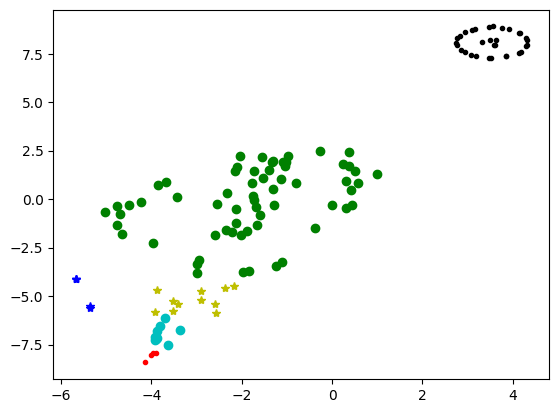

In [52]:
# TSNE
tsne=TSNE(n_components=2,random_state=2023)
tsne.fit_transform(X)

tsne=pd.DataFrame(tsne.embedding_) #转换数据格式


color = ['r.','go','b*','k.','co','y*','c.','mo']
for c in range(n_clusters):
    d = tsne[predict==c]
    plt.plot(d[0],d[1],color[c])
plt.show()

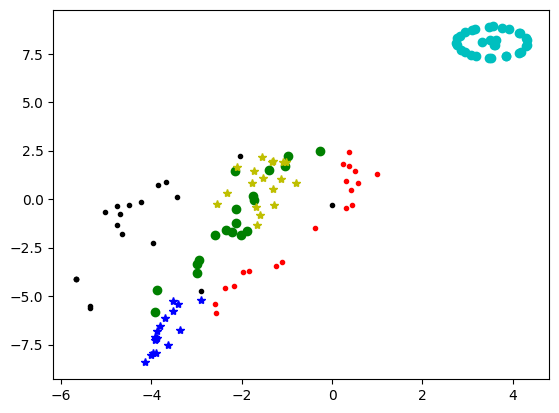

In [54]:
for c in range(n_clusters):
    d = tsne[label==c]
    plt.plot(d[0],d[1],color[c])
plt.show()